# 3D Protein Pose Recovery - Robustness to Unseen Protein

Through the following model, we consider that a cryo-EM measurement (i.e. 2D projection) $\mathbf{y}_i \in \mathbb{R}^{M}$ is acquired through
\begin{equation}
\label{eq:linear-forward-model}
\mathbf{y}_i={\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x+\mathbf n,
\end{equation}
where $\mathbf x \in \mathbb{R}^{V}$ is the unknown 3D density map [*DiMaio et al.*](https://academic.oup.com/bioinformatics/article/23/21/2851/374177) (Coulomb potential). The operator $\mathbf P_{\theta_i}: \mathbb R^V \to \mathbb R^M$ is the projection along the 3D pose $\theta_i$ (i.e., the x-ray transform). The operator $\mathbf S_\mathbf{t}: \mathbb R^M \to \mathbb R^M$ is a shift of the projection by $\mathbf{t}=(t_1, t_2)$. The convolution operator $\mathbf {C}_{\boldsymbol\varphi}: \mathbb R^M \to \mathbb R^M$ models the microscope contrast transfer function (CTF) with parameters $\boldsymbol\varphi=(d_1, d_2, \alpha_{\rm ast})$, that are, respectively, the defocus-major, the defocus-minor and the angle of astigmatism. Finally, $\mathbf n \in \mathbb{R}^{M}$ represents an additive noise. Our goal is then to recover the angles $\theta_i$ from every projection $\mathbf y_i$. 

Final **goal**: We have $N$ protein 3D volumes that are used to create the training set of 2D projections $\{\mathbf y_{N, i}^{train}\}$. Another, unseen protein 3D volume $\mathbf x^{test}$ is used to create the test set of 2D projections $\{\mathbf y_i^{test}\}$. The set of projections is created using the projection $\mathbf P_{\theta_i}$ along the 3D pose $\theta_i$ as well as all the other operators (noise $\mathbf n$, CTF $\mathbf C_\varphi$, shift $\mathbf S_{\mathbf t}$) specified in the equation above. 


  $\{\mathbf x_1^{train}, ..., \mathbf x_N^{train}\}  \rightarrow \{\mathbf y_{N, i}^{train}\} = \{{\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x_N^{train}+\mathbf n\}$
  

  $\mathbf x^{test} \rightarrow \{\mathbf y_i^{test}\} =\{{\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x^{test}+\mathbf n\}$

In [1]:
import sys
sys.path.append("..") 
from cryoem.projections import generate_2D_projections
from cryoem.plots import plot_projection, plot_detector_pixels, plot_angles_count
from cryoem.preprocessing import preprocessing, train_val_test_split
from cryoem.distance_estimation import train_distance_estimation
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl
from cryoem.conversions import quaternion2euler
import matplotlib.pyplot as plt
from cryoem.conversions import d_q, euler2quaternion
from cryoem.reconstruction import reconstruct
from cryoem.plots import plot_dP_dQ
import h5py
import ipyvolume as ipv
import numpy as np
import pathlib
import tensorflow as tf
from tensorflow.python.client import device_lib 
from numba import cuda
tf.__version__

'2.0.0'

In [2]:
!echo $CUDA_VISIBLE_DEVICES

0


In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3881710435248936776
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1415767356970944585
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15761495008282759154
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7552725812
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5561650593195810149
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:0a:00.0, compute capability: 6.1"
]


## (1) Generate Sythetic Data

In [4]:
MRC_DIR         = "/home/jelena/MRC"  #"/mnt/scratch/students/MRC"
RESULTS_DIR     = "/home/jelena/data"  #"/mnt/scratch/students"
pathlib.Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

In [5]:
NUM_TRAIN_PROTEINS = 3
NUM_TEST_PROTEINS  = 1

In [6]:
PROTEINS  = [
             
             
             '2x8q',
             
             

             
             
             
             '6ulg',
             #'5a79',
             '6vaa',
             '6vum',
             '6w2d',
             '6xt9',
             '7jg8',
             '5v4s',
             '6gv9',
             '6hu9',
            '5zzm',
            '6lve',
            '6o6c',
            '6peq',
            '6red',
            '5oh0',]
PROTEINS_TRAIN = PROTEINS[:NUM_TRAIN_PROTEINS]
PROTEINS_TEST  = PROTEINS[NUM_TRAIN_PROTEINS:NUM_TRAIN_PROTEINS+NUM_TEST_PROTEINS]

In [7]:
# 2.0, 1.0, 0.5 - 1/4
# 2.0, 1.0, 2.0 - 1
# 2.0, 1.0, 1.0 - 1/2

In [8]:
PROJECTIONS_NUM_SINGLE = 1000
ANGLE_COVERAGE         = [1.9, 0.4, 1.0]
ANGLE_SHIFT            = [0., 0., 0.]

In [9]:
PROTEINS_TRAIN + PROTEINS_TEST

['2x8q', '6ulg', '6vaa', '6vum']

In [10]:
# generate sythetic data - 2D projections and their corresponding orientations from a given 3D protein
for protein in PROTEINS_TRAIN + PROTEINS_TEST: 
    generate_2D_projections(input_file_path=f"{MRC_DIR}/{protein}.mrc", 
                            ProjNber=PROJECTIONS_NUM_SINGLE,
                            AngCoverage=ANGLE_COVERAGE,
                            AngShift=ANGLE_SHIFT,
                            angles_gen_mode="uniform_angles",
                            output_file_name=f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5")
    cuda.current_context().reset() 

* Loading the dataset *

Projections: (1000, 218, 218)
Angles: (1000, 3)

* Loading the dataset *

Projections: (1000, 748, 748)
Angles: (1000, 3)

* Loading the dataset *

Projections: (1000, 550, 550)
Angles: (1000, 3)

* Loading the dataset *

Projections: (1000, 647, 647)
Angles: (1000, 3)



In [10]:
# read stored data for further processing
projections_train = []
projections_original_train = []
angles_true_train = []
print(f"* Reading train dataset *")
for protein in PROTEINS_TRAIN:
    data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
    projections = data['Projections']
    angles_true = np.array(data['Angles'])
    projections_train.extend(projections)
    projections_original_train.extend(projections)
    angles_true_train.extend(angles_true)
    print(f"--- protein: {protein} ---")
    print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
    print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")

    cuda.current_context().reset() 

projections_test = []
projections_original_test = []
angles_true_test = []
print(f"\n* Reading test dataset *")
for protein in PROTEINS_TEST:
    data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
    projections = data['Projections']
    angles_true = np.array(data['Angles'])
    projections_test.extend(projections)
    projections_original_test.extend(projections)
    angles_true_test.extend(angles_true)
    print(f"--- protein: {protein} ---")
    print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
    print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")
    
    cuda.current_context().reset() 

* Reading train dataset *
--- protein: 2x8q ---
1000 projections of images with dimension (218, 218) pixels
1000 sets of 3 ground truth rotation angles (Z-Y-Z axes) of corresponding projection images
--- protein: 6ulg ---
1000 projections of images with dimension (748, 748) pixels
1000 sets of 3 ground truth rotation angles (Z-Y-Z axes) of corresponding projection images
--- protein: 6vaa ---
1000 projections of images with dimension (550, 550) pixels
1000 sets of 3 ground truth rotation angles (Z-Y-Z axes) of corresponding projection images

* Reading test dataset *
--- protein: 6vum ---
1000 projections of images with dimension (647, 647) pixels
1000 sets of 3 ground truth rotation angles (Z-Y-Z axes) of corresponding projection images


In [11]:
projections_train = np.array(projections_train)
projections_original_train = np.array(projections_original_train)
angles_true_train = np.array(angles_true_train)

projections_test = np.array(projections_test)
projections_original_test = np.array(projections_original_test)
angles_true_test = np.array(angles_true_test)

/home/jelena/miniconda/envs/protein_reconstruction/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/home/jelena/miniconda/envs/protein_reconstruction/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [12]:
from cryoem.plots import plot_detector_pixels, plot_rotvec

In [14]:
plot_detector_pixels(angles_true_test)

In [15]:
plot_rotvec(angles_true_test)

In [16]:
# ipv.screenshot()

## (2) Preprocessing Data

In [13]:
NOISE_VAR_SCALE = 1   # it takes max px value to be the variance, since all proteins have it different
TRANSLATION = 5

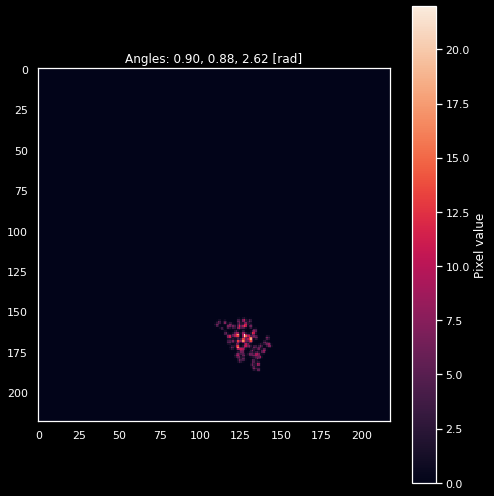

In [14]:
plot_projection(projections_train[0], angles=angles_true_train[0])

In [15]:
projections_train = preprocessing(projections_train, PROJECTIONS_NUM_SINGLE, rescale_dim=128, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=1)

--- Preprocessing projections ---
Protein # 1
Image rescaled: from dimension 218 to 128
Global standardization
	Image shape: (128, 128)
	Data Type: float64
	Mean: 0.047 | Std: 0.519
	Min:  0.000 | Max: 26.222
	Mean: -0.000 | Std: 1.000
	Min:  -0.091 | Max: 50.388
Noise:
Variance= 50.38750076293945
Translation:
left_limit=-5, peak_limit=0, right_limit=5
Protein # 2
Image rescaled: from dimension 748 to 128
Global standardization
	Image shape: (128, 128)
	Data Type: float64
	Mean: 0.465 | Std: 5.298
	Min:  0.000 | Max: 152.942
	Mean: 0.000 | Std: 1.000
	Min:  -0.088 | Max: 28.778
Noise:
Variance= 28.777645111083984
Translation:
left_limit=-5, peak_limit=0, right_limit=5
Protein # 3
Image rescaled: from dimension 550 to 128
Global standardization
	Image shape: (128, 128)
	Data Type: float64
	Mean: 0.694 | Std: 6.199
	Min:  0.000 | Max: 156.936
	Mean: 0.000 | Std: 1.000
	Min:  -0.112 | Max: 25.204
Noise:
Variance= 25.204124450683594
Translation:
left_limit=-5, peak_limit=0, right_limit=5


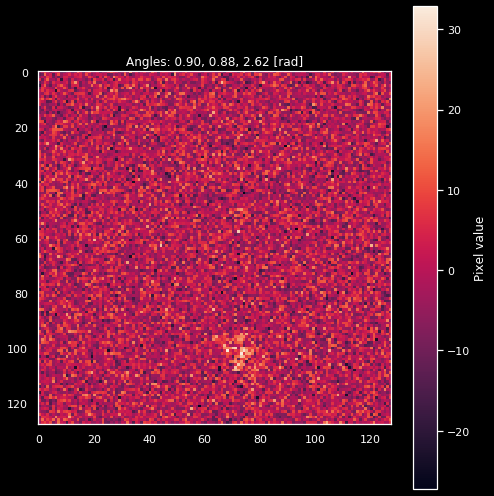

In [16]:
plot_projection(projections_train[0], angles=angles_true_train[0])

In [17]:
# do the same to test set projections
projections_test = preprocessing(projections_test, PROJECTIONS_NUM_SINGLE, rescale_dim=128, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=1)

--- Preprocessing projections ---
Protein # 1
Image rescaled: from dimension 647 to 128
Global standardization
	Image shape: (128, 128)
	Data Type: float64
	Mean: 0.697 | Std: 5.576
	Min:  0.000 | Max: 140.029
	Mean: -0.000 | Std: 1.000
	Min:  -0.125 | Max: 24.987
Noise:
Variance= 24.986907958984375
Translation:
left_limit=-5, peak_limit=0, right_limit=5


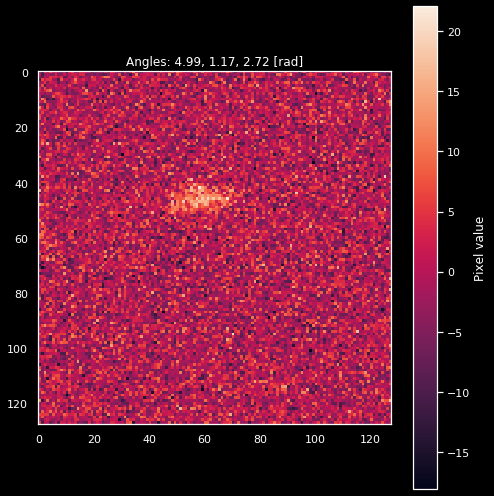

In [18]:
plot_projection(projections_test[0], angles=angles_true_test[0])

## (3) Distance Learning

In [19]:
PROJECTIONS_NUM = NUM_TRAIN_PROTEINS * PROJECTIONS_NUM_SINGLE
PROJECTIONS_NUM

3000

In [20]:
DE_LOGS_DIR = f"{RESULTS_DIR}/distance_estimation"
DE_DESCRIPTION = "full_pipeline_unseen_proteins"

In [21]:
train_idx, val_idx, test_idx, train_pairs_num, val_pairs_num = train_val_test_split(PROJECTIONS_NUM, test_size=0.0001, val_size=0.35, train_percent=0.01, val_percent=0.01, indices_file="")

TRAIN: 1.00 x 0.65 = 0.65 =>  1949 imgs => max pairs:    3798601   |   37986
TEST :             0.0001 =>     1 imgs => max pairs:          1   |   all
VAL  : 1.00 x 0.35 = 0.35 =>  1050 imgs => max pairs:    1102500   |   11025
Indices stored in 


In [ ]:
model, history = train_distance_estimation(X=projections_train, y=angles_true_train, 
                                           train_idx=train_idx, 
                                           val_idx=val_idx,
                                           epochs=70,
                                           batch_size=256,  #512 latest 
                                           learning_rate=1e-3, 
                                           limit_style="random", 
                                           path_logs_training=DE_LOGS_DIR, 
                                           training_description=DE_DESCRIPTION,
                                           training_steps=train_pairs_num,
                                           validation_steps=val_pairs_num, 
                                           plot=True,
                                           gpus=None)

Data created in 5.6391212940216064 sec
Data created in 0.8626058101654053 sec
Input images shape (128, 128, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
________________________________________________________________________________

In [22]:
# read stored model
model_filename = f"{DE_LOGS_DIR}/training/{DE_DESCRIPTION}.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [23]:
# learned distance function
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

<Figure size 432x288 with 0 Axes>

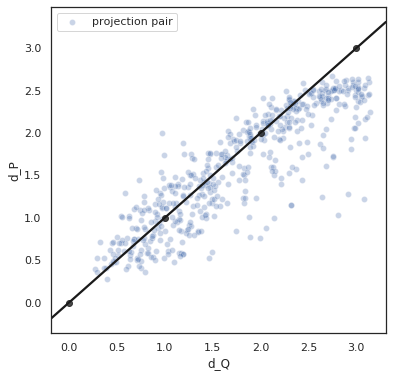

<Figure size 432x288 with 0 Axes>

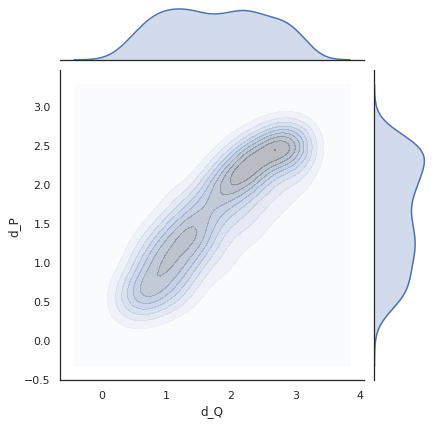

Variance = 0.40619725502451487
Min. angle recovery loss possible = 0.16467395176681515


In [24]:
# dP/dQ ratio plot
batch_size = 512
idx1 = list(np.random.choice(range(1000), size=batch_size))
idx2 = list(np.random.choice(range(1000), size=batch_size))

q1_true = euler2quaternion([angles_true_train[i] for i in idx1])
q2_true = euler2quaternion([angles_true_train[i] for i in idx2])

p1 = [projections_train[i] for i in idx1]
p2 = [projections_train[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

plot_dP_dQ(dP_values, dQ_values, f"{DE_LOGS_DIR}/dPdQ.png");

In [ ]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

## (4) Angle Recovery

In [25]:
from cryoem.angle_recovery import train_angle_recovery

In [26]:
AR_LOGS_DIR = f"{RESULTS_DIR}/angle_recovery"
AR_TRAINING_DESCRIPTION = "full_pipeline_unseen_proteins"

In [27]:
projections_test.shape

(1000, 128, 128, 1)

In [28]:
# QUATERNION VARIABLE
import time
import numpy as np
from IPython import display as IPyDisplay
from tensorflow.keras.optimizers import Adam
import seaborn as sns; sns.set(style="white", color_codes=True)
from tensorflow_graphics.geometry.transformation import quaternion
from cryoem.conversions import euler2quaternion, d_q, quaternion2euler
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from pathlib import Path

# TODO: add constraint on quaternion Variables


def angles_transpose(angles):
    angles = angles.copy()
    cols = [2, 1, 0]
    idx = np.empty_like(cols)
    idx[cols] = np.arange(len(cols))
    angles[:] = -angles[:, idx]
    return angles

def quaternion_constraint(low_ang, high_ang):
    
    def _inner(q):
        e = quaternion2euler(q)

        a0, a1, a2 = tf.unstack(e, axis=-1)
        a0 = tf.clip_by_value(a0, low_ang[0], high_ang[0])
        a1 = tf.clip_by_value(a1, low_ang[1], high_ang[1])
        a2 = tf.clip_by_value(a2, low_ang[2], high_ang[2])

        e_new = tf.stack((a0, a1, a2), axis=-1)
        q_new = euler2quaternion(e_new)
        return q_new

    return _inner
    


def train_angle_recovery(steps, 
                         batch_size, 
                         in_data, 
                         distance_fn, 
                         file_name,
                         limit_distance=np.pi,
                         low_ang_const=[0.0, 0.0, 0.0],
                         high_ang_const=[2.0, 0.4, 2.0],
                         q_predicted=None,
                         angles_true=None,
                         learning_rate=0.01,
                        constraint=False): 

    time_start = time.time()
    collect_data = []
    optimizer = Adam(learning_rate=learning_rate)

    #low_ang = [0.0*np.pi, 0.0*np.pi, 0.0*np.pi]
    low_ang = list(map(lambda x: x*np.pi, low_ang_const))
    #high_ang = [2.0*np.pi, 0.4*np.pi, 2.0*np.pi] 
    high_ang = list(map(lambda x: x*np.pi, high_ang_const))           
    euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(in_data), 3))
    if q_predicted:
        # continue where left off
        if constraint:
            q_predicted = [tf.Variable(q, constraint=quaternion_constraint(low_ang, high_ang)) for q in q_predicted]
        else:
            q_predicted = [tf.Variable(q) for q in q_predicted]
    else:
        # optimize from scratch
        if constraint:
            q_predicted = [tf.Variable(q, constraint=quaternion_constraint(low_ang, high_ang)) for q in euler2quaternion(euler)]
        else:
            q_predicted = [tf.Variable(q) for q in euler2quaternion(euler)]

    if in_data.shape[1] == 3:
        in_data = euler2quaternion(in_data)

    losses = np.empty(steps)
    report = f"Shape of projections: {in_data.shape}"
    found_minimizer = False

    print(time.time()-time_start)

    for step, idx1, idx2 in sample_iter(steps, range(len(in_data)), batch_size, style="random"):
        q1 = [q_predicted[i] for i in idx1]
        q2 = [q_predicted[i] for i in idx2]
        q1 = np.array(q1)
        q2 = np.array(q2)

        # Compute distances
        in1 = [in_data[i] for i in idx1]
        in2 = [in_data[i] for i in idx2]
        in1 = np.array(in1)
        in2 = np.array(in2)

        distance_target = distance_fn(in1, in2)

        # WORK ONLY WITH LIMITED DISTANCES 
        indices_le2 = np.where(distance_target<limit_distance)[0]
        distance_target = np.take(distance_target, indices_le2)
        q1 = list(np.take(q1, indices_le2))
        q2 = list(np.take(q2, indices_le2))
        in1 = list(np.take(in1, indices_le2))
        in2 = list(np.take(in2, indices_le2))

        # Optimize by gradient descent.
        losses[step-1], gradients = gradient(q1, q2, distance_target)
        optimizer.apply_gradients(zip(gradients, q1 + q2))

        # Visualize progress periodically
        if step % 10 == 0:
            a = np.zeros((len(q_predicted), 4))
            for i, e in enumerate(q_predicted):
                a[i] = e.numpy()
            collect_data.append(a)

            plt.close();
            sns.set(style="white", color_codes=True)
            sns.set(style="whitegrid")

            if angles_true is not None:
                fig, axs = plt.subplots(1, 3, figsize=(24,7))

                # Optimization loss subplot
                axs[0].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                axs[0].set_xlabel('time [s]')
                axs[0].set_ylabel('loss');
                axs[0].set_title(f"[{step}/{steps}] Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

                # NT - Distance count subplot (full)
                d2 = d_q(R.from_euler('zyz', angles_true).as_quat(), q_predicted)
                axs[1].set_xlim(0, np.pi)
                axs[1].set_title(f"[{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                s = sns.distplot(d2, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
                max_count = int(max([h.get_height() for h in s.patches]))
                axs[1].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

                # T - Distance count subplot (full)
                angles_true_T = angles_transpose(angles_true)
                d2 = d_q(R.from_euler('zyz', angles_true_T).as_quat(), q_predicted)
                axs[2].set_xlim(0, np.pi)
                axs[2].set_title(f"[{step}/{steps}] TRANSPOSED Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
                max_count = int(max([h.get_height() for h in s.patches]))
                axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
            else:
                fig, axs = plt.subplots(figsize=(10,7))

                # Optimization loss subplot
                axs.plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                axs.set_xlabel('time [s]')
                axs.set_ylabel('loss');
                axs.set_title(f"[{step}/{steps}] Angle recovery optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")


            IPyDisplay.clear_output(wait=True)
            IPyDisplay.display(plt.gcf())
            plt.close();
            time.sleep(0.1)

            Path(file_name).mkdir(parents=True, exist_ok=True)
            np.savez(file_name, quaternion.normalize(q_predicted).numpy(), losses, np.array(collect_data))

            if found_minimizer:
                time_elapsed = time.time() - time_start
                report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'
                break;

        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'

        if step >= 1001 and np.mean(losses[step-1001:step-1]) < 1e-8:
            found_minimizer = True

        if step >= 2001 and np.abs(np.mean(losses[step-1000:step-1])-np.mean(losses[step-2000:step-1000])) < 1e-7:
            found_minimizer = True

    print(report)
    return quaternion.normalize(q_predicted).numpy(), losses, np.array(collect_data)

def sample_iter(steps, projection_idx, num_pairs, style="random", k=None):

    for step in range(1, steps+1):
        if not k and style != "random":
            raise ValueError("Please specify k for kNN for sample_pairs method")

        if style=="random":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            idx2 = list(np.random.choice(projection_idx, size=num_pairs))

        elif style=="knn":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]

        elif style=="knn_and_random":
            # select random sample for the first element of pair
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))

            # half from kNN
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:num_pairs//2]]
            idx2_random = list(np.random.randint(0, num_projections, num_pairs//2))
            # half random
            idx2 = idx2_knn + idx2_random

        yield step, idx1, idx2


        
def loss(q1_predicted, q2_predicted, distance_target):
    
    distance_estimated = d_q(q1_predicted, q2_predicted)
    
    prob_target, _    = np.histogram(distance_target, bins=31, density=True)
    prob_estimated, _ = np.histogram(distance_estimated, bins=31, density=True)
    
    return tf.reduce_mean(tf.pow(distance_estimated - distance_target, 2)) + tf.keras.losses.kullback_leibler_divergence(distance_target, distance_estimated)

def gradient(q1_predicted, q2_predicted, distance_target):
    with tf.GradientTape() as tape:
        loss_value = loss(q1_predicted, q2_predicted, distance_target)
    gradient = tape.gradient(loss_value, q1_predicted + q2_predicted)

    return loss_value, gradient



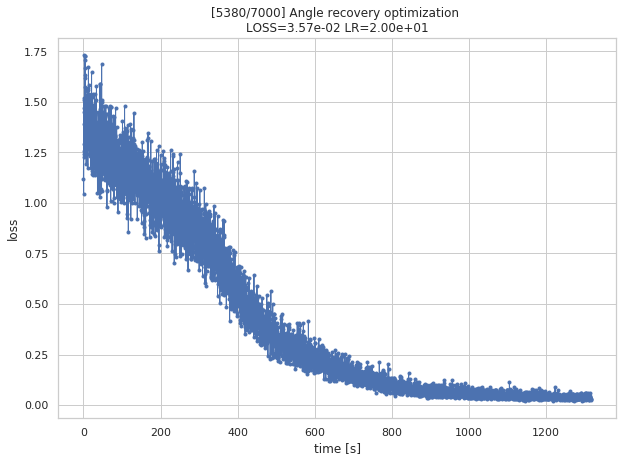

In [ ]:
q_predicted, losses, q_all = train_angle_recovery(steps=7000, 
                                                 batch_size=128, 
                                                 in_data=projections_test, 
                                                 distance_fn=d_p, 
                                                 learning_rate=20, 
                                                 limit_distance=np.pi,
                                                 low_ang_const=ANGLE_SHIFT,
                                                 high_ang_const=[sum(x) for x in zip(ANGLE_SHIFT, ANGLE_COVERAGE)],
                                                 file_name=f"{AR_LOGS_DIR}/{AR_TRAINING_DESCRIPTION}",
                                                 constraint=False)

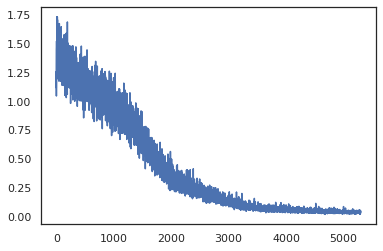

In [23]:
data = np.load(f"{AR_LOGS_DIR}/{AR_TRAINING_DESCRIPTION}.npz")
q_predicted, losses, collect_data = data['arr_0'], data['arr_1'], data['arr_2']
plt.plot(data["arr_1"][:5300])

In [24]:
angles_predicted = quaternion2euler(q_predicted)

## (5) Angle Alignment

In [25]:
from cryoem.angle_alignment import training_angle_alignment

m= [1.0, 1.0, 1.0, 1.0] 
trajectory_first= [1.46402962 3.99342284 2.78845077 3.67342003 1.00338646 3.61583715] 
loss_first= 2.4606481761624437 
trajectory_last= [ 15.34785459 -11.31986357   0.52883362  51.28956629  30.72230093
  34.81491683] 
loss_last= 1.3287116790838611


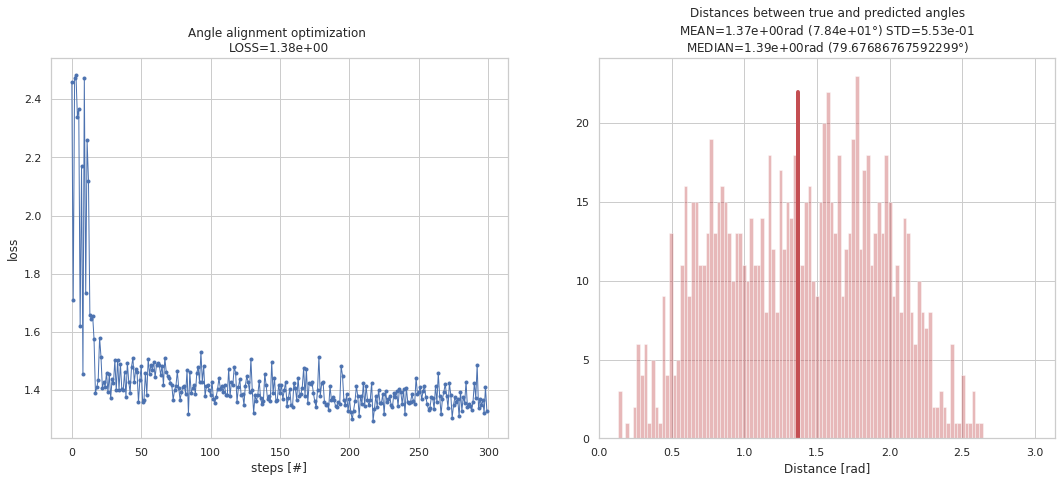

In [62]:
%matplotlib inline
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                                    steps=300, 
                                                                    batch_size=256, 
                                                                    optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                                    angles_true=e1, 
                                                                    angles_predicted=angles_predicted,
                                                                    threshold=None)

In [54]:
q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)
angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

In [38]:
from cryoem.plots import plot_rays, plot_iterations_rotvec, plot_rotvec,plot_angles_count, plot_distances_count

In [63]:
plot_rotvec(e1)

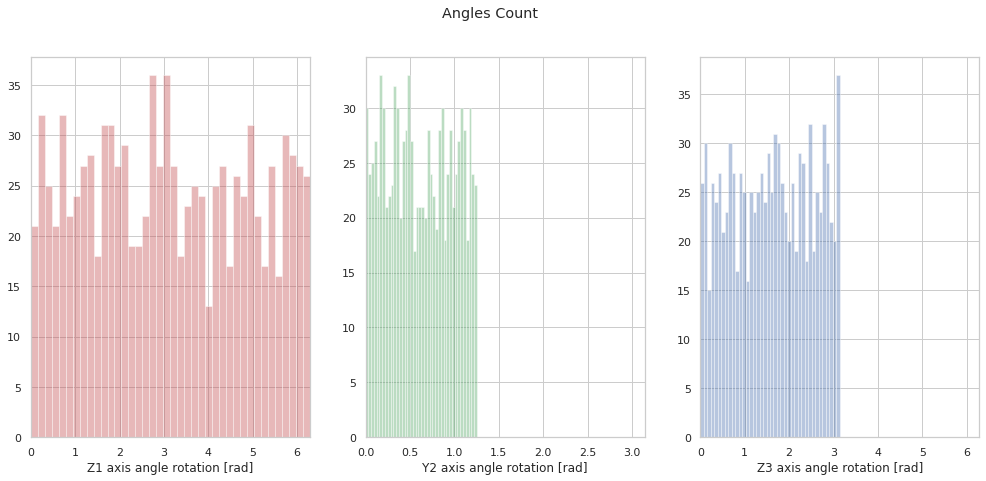

In [33]:
plot_angles_count(angles_true_test)

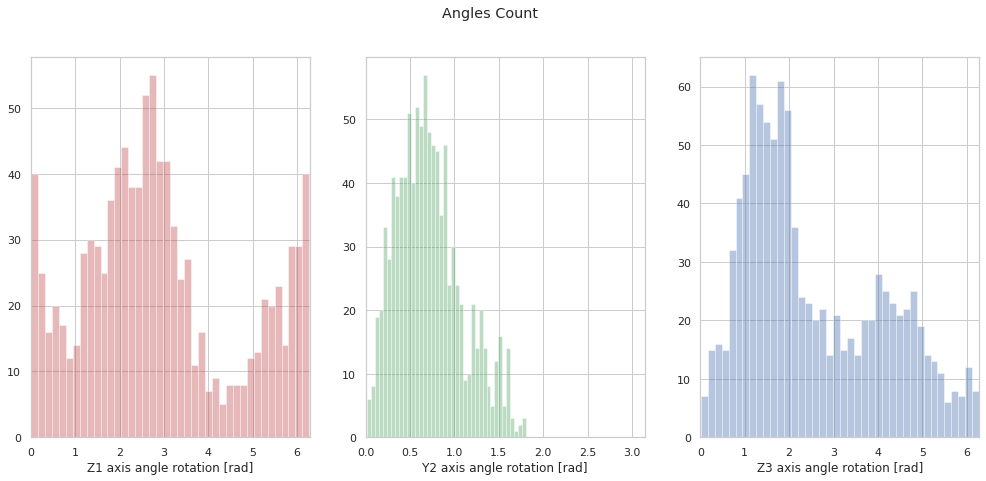

In [36]:
plot_angles_count(angles_predicted_rotated.numpy())

<module 'matplotlib.pyplot' from '/home/jelena/miniconda/envs/protein_reconstruction/lib/python3.6/site-packages/matplotlib/pyplot.py'>

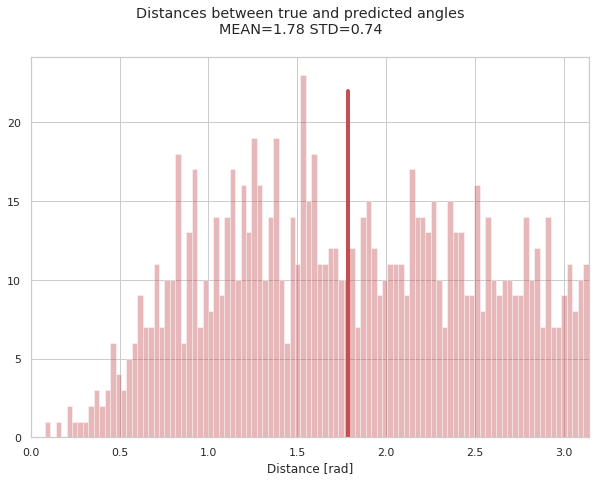

In [39]:
plot_distances_count(angles_predicted_rotated.numpy(), angles_true_test)

In [64]:
plot_iterations_rotvec(collect_data, e1, interval=1000, connections=False, selected=None)

In [57]:
angles_predicted_rotated.numpy()

array([[-1.20168677,  0.55572694,  1.0638043 ],
       [ 2.12202864,  0.67972442, -0.13187541],
       [ 0.37918579,  0.32061938, -0.5751024 ],
       ...,
       [ 0.76344112,  1.18884859,  0.04588628],
       [-2.31175723,  0.93282292, -3.13462754],
       [-2.44220243,  0.55787919, -1.72081717]])

In [58]:
e1

array([[ 3.12036383,  0.60461579, -2.89702738],
       [-0.02398633,  0.7131451 ,  1.568984  ],
       [-0.29294985,  0.82768889,  1.97682361],
       ...,
       [-2.90970864,  0.93390763, -2.00981975],
       [-2.74704842,  0.89951342, -2.54544799],
       [ 0.50683637,  0.38793428,  0.85183839]])

In [41]:
from scipy.spatial.transform import Rotation as R

In [60]:
e1 = R.from_euler('zyz', angles_true_test)
rv1 = e1.as_rotvec()
#print(e1)

rv1_new = np.empty(rv1.shape)
r = 1.0
rv1_new[:,0] = -rv1[:,0]
rv1_new[:,1] = -r*(np.sin(rv1[:,2]))#+(np.sin(rv1[:,1]))
rv1_new[:,2] = -r*(np.cos(rv1[:,2]))#+(np.cos(rv1[:,1]))

print()
e1 = R.from_rotvec(rv1_new).as_euler('zyz')
print(e1)


[[ 2.60860786  0.61028027  2.86546084]
 [-1.57387075  0.61419689  2.55876022]
 [-1.48621423  0.88373776  2.4832288 ]
 ...
 [ 2.85944952  1.05700018 -2.57359927]
 [ 3.00542266  1.00118955 -3.08954682]
 [ 0.16565787  0.88211054  0.32738263]]


In [61]:
plot_iterations_rotvec(collect_data, e1, interval=1000, connections=False, selected=None)

In [43]:
rv1 = R.from_rotvec([[0,       0, -np.pi ], 
                     [np.pi/2, 0, np.pi/2]])
e1 = rv1.as_euler('zyz')
print(e1)

#rv1_new = np.empty(rv1.shape)
#r = 2.0
#rv1_new[:,0] = -rv1[:,0]
#rv1_new[:,1] = -r*(np.sin(rv1[:,2]))+(np.sin(rv1[:,1]))
#rv1_new[:,2] = -r*(np.cos(rv1[:,2]))+(np.cos(rv1[:,1]))

print()
e1 = R.from_euler('zyz', e1).as_rotvec()
print(e1)

[[-3.14159265  0.          0.        ]
 [ 2.53032762  1.37234625 -0.61126504]]

[[ 0.00000000e+00  0.00000000e+00 -3.14159265e+00]
 [ 1.57079633e+00  6.88125933e-17  1.57079633e+00]]


In [ ]:
e1 = R.from_euler('xyz', [[0, 0, -np.pi], [np.pi, np.pi, 0]])
rv1 = e1.as_rotvec()
print(rv1)

#rv1_new = np.empty(rv1.shape)
#r = 2.0
#rv1_new[:,0] = -rv1[:,0]
#rv1_new[:,1] = -r*(np.sin(rv1[:,2]))+(np.sin(rv1[:,1]))
#rv1_new[:,2] = -r*(np.cos(rv1[:,2]))+(np.cos(rv1[:,1]))

e1 = R.from_rotvec(rv1).as_euler('xyz')
print(e1)

In [ ]:
np.min(angles_true_test, axis=0)

In [ ]:
np.min(angles_predicted, axis=0)

In [ ]:
np.max(angles_true_test, axis=0)

In [ ]:
np.max(angles_predicted, axis=0)

In [ ]:
e2 = R.from_euler('zyz', angles_true_test)
rv2 = e2.as_rotvec()

In [ ]:
e1 = R.from_euler('zyz', angles_true_test)
rv1 = e1.as_rotvec()

rv1_new = np.empty(rv1.shape)
r = 2.0
rv1_new[:,0] = -rv1[:,0]
rv1_new[:,1] = -r*(np.sin(rv1[:,2]))+(np.sin(rv1[:,1]))
rv1_new[:,2] = -r*(np.cos(rv1[:,2]))+(np.cos(rv1[:,1]))

e1 = R.from_rotvec(rv1_new).as_euler('zyz')

In [ ]:
plot_rotvec(e1)

---

In [ ]:
plot_rotvec(angles_predicted)

In [ ]:
plot_rotvec(angles_true_test)

In [ ]:
trajectory.shape

## (6) Reconstruction

In [ ]:
REC_LOGS_DIR = f"{RESULTS_DIR}/reconstruction"
REC_DESCRIPTION = "full_pipeline_test.mrc"

In [ ]:
angles_predicted

In [ ]:
angles_predicted_rotated

In [ ]:
angles_true

In [ ]:
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
from cryoem.rotation_matrices import RotationMatrix
import astra
import mrcfile
from pathlib import Path

def reconstruct(projections, angles, mrc_filename=None, overwrite=False):
    # Generate orientation vectors based on angles
    orientation_vectors   = RotationMatrix(angles)

    # Reshape projections correctly 
    projections1 = np.transpose(projections, (1, 0, 2))
    
    # Get projection dimension
    proj_size = projections1.shape[0]

    # Create projection 2D geometry in ASTRA
    proj_geom = astra.create_proj_geom('parallel3d_vec', proj_size, proj_size, orientation_vectors)
    #proj_geom = astra.create_proj_geom('parallel3d', 0.5, 0.5, proj_size, proj_size, orientation_vectors)
    projections_id = astra.data3d.create('-sino', proj_geom, projections1)

    # Create reconstruction.
    vol_geom = astra.creators.create_vol_geom(proj_size, proj_size, proj_size)
    reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
    alg_cfg = astra.astra_dict('BP3D_CUDA')
    alg_cfg['ProjectionDataId'] = projections_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id
    algorithm_id = astra.algorithm.create(alg_cfg)
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data3d.get(reconstruction_id)


    # Limit and scale reconstruction.
    reconstruction[reconstruction < 0] = 0
    reconstruction /= np.max(reconstruction)
    reconstruction = np.round(reconstruction * 255).astype(np.uint8)

    # Cleanup.
    astra.algorithm.delete(algorithm_id)
    astra.data3d.delete(reconstruction_id)
    astra.data3d.delete(projections_id)


    # Save reconstruction to mrc file for chimera
    if mrc_filename:
        Path(mrc_filename).parent.mkdir(parents=True, exist_ok=True)
        with mrcfile.new(mrc_filename, overwrite=overwrite) as mrc:
            mrc.set_data(reconstruction)
        
    return reconstruction

def reconstruct_from_file(input_file, limit=3000, mrc_filename=None):
    data = np.load(f'data/{input_file}.npz')
    projections, angles = data["arr_0"].astype(np.float64)[:limit, :, :], data["arr_1"].astype(np.float64)[:limit, :]

    return reconstruct(projections, angles, mrc_filename)


In [ ]:
reconstruction_pred = reconstruct(projections_original, angles_predicted, mrc_filename=False, overwrite=False)
reconstruction_pred = reconstruction_pred.astype(np.float)

In [ ]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 2

volume = reconstruction_pred 
volume[volume<50.] = np.nan

x = np.arange(volume.shape[0])[::step, None, None]
y = np.arange(volume.shape[1])[None, ::step, None]
z = np.arange(volume.shape[2])[None, None, ::step]
x, y, z = np.broadcast_arrays(x, y, z)
c = volume[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(),
           y.ravel(),
           z.ravel(), alpha=0.5, s=0.5,
           c=c)

In [ ]:
reconstruction = reconstruct(projections_original, angles_predicted_rotated, mrc_filename=f"{REC_LOGS_DIR}/{REC_DESCRIPTION}", overwrite=True)
reconstruction = reconstruction.astype(np.float)

In [ ]:
reconstruction_true = reconstruct(projections_original, angles_true, mrc_filename=False, overwrite=False)
reconstruction_true = reconstruction_true.astype(np.float)

In [ ]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 2

volume = reconstruction 
volume[volume<50.] = np.nan

x = np.arange(volume.shape[0])[::step, None, None]
y = np.arange(volume.shape[1])[None, ::step, None]
z = np.arange(volume.shape[2])[None, None, ::step]
x, y, z = np.broadcast_arrays(x, y, z)
c = volume[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(),
           y.ravel(),
           z.ravel(), alpha=0.5, s=0.5,
           c=c)

volume_true = reconstruction_true 
volume_true[volume_true<70.] = np.nan

x_t = np.arange(volume_true.shape[0])[::step, None, None]
y_t = np.arange(volume_true.shape[1])[None, ::step, None]
z_t = np.arange(volume_true.shape[2])[None, None, ::step]
x_t, y_t, z_t = np.broadcast_arrays(x_t, y_t, z_t)
c_t = volume_true[::step,::step,::step].ravel()

#fig = plt.figure(figsize = (10, 10))
#ax = fig.gca(projection='3d')
# ax.scatter(x_t.ravel(),
#            y_t.ravel(),
#            z_t.ravel(), alpha=0.5, s=0.5,
#            c=c_t)

In [ ]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 2

volume_true = reconstruction_true 
volume_true[volume_true<50.] = np.nan

x_t = np.arange(volume_true.shape[0])[::step, None, None]
y_t = np.arange(volume_true.shape[1])[None, ::step, None]
z_t = np.arange(volume_true.shape[2])[None, None, ::step]
x_t, y_t, z_t = np.broadcast_arrays(x_t, y_t, z_t)
c_t = volume_true[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x_t.ravel(),
           y_t.ravel(),
           z_t.ravel(), alpha=0.5, s=0.5,
           c=c_t)

In [ ]:
%matplotlib inline
plt.hist(reconstruction.ravel()-reconstruction_true.ravel());
plt.show()

In [ ]:
reconstruction.ravel()[~np.isnan(reconstruction.ravel())]

In [ ]:
reconstruction_true.ravel()[~np.isnan(reconstruction_true.ravel())]

In [ ]:
volume_true.ravel()[~np.isnan(volume_true.ravel())]

In [ ]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 2

volume_true = reconstruction_true - reconstruction
#volume_true[volume_true<50.] = np.nan

x_t = np.arange(volume_true.shape[0])[::step, None, None]
y_t = np.arange(volume_true.shape[1])[None, ::step, None]
z_t = np.arange(volume_true.shape[2])[None, None, ::step]
x_t, y_t, z_t = np.broadcast_arrays(x_t, y_t, z_t)
c_t = volume_true[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x_t.ravel(),
           y_t.ravel(),
           z_t.ravel(), alpha=0.5, s=0.5,
           c=c_t)

In [ ]:
volume_true = reconstruction_true - reconstruction

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(reconstruction_true.ravel(), reconstruction.ravel())
#np.mean_square_error(volume_true.ravel()[~np.isnan(volume_true.ravel())])
mse